In [ ]:
pip install kagglehub

This installs the KaggleHub package, which allows us to pull datasets directly from Kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mercyknjoroge","key":"4430ecdb33a1257ed2efad9170c854e4"}'}

In [ ]:
import os
import shutil

# Make kaggle folder and move JSON
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set file permissions
os.chmod("/root/.kaggle/kaggle.json", 600)


In [ ]:
import kagglehub

# Download the Amazon Reviews dataset
path = kagglehub.dataset_download("bittlingmayer/amazonreviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amazonreviews


Getting the dataset from Kaggle using an api key

In [ ]:
import os

# List all files in the dataset folder
os.listdir(path)


['test.ft.txt.bz2', 'train.ft.txt.bz2']

1. DATA UNDERSTANDING

In [ ]:
import pandas as pd
import bz2 #helps unzip the files

# Step 1: Define the path to your training file
train_file = path + "/train.ft.txt.bz2"

# Step 2: Read lines and split into label + text(decided to do this because ive previewed the dataset from kaggle and it needs to be split and labelled)
data = []
with bz2.open(train_file, 'rt', encoding='utf-8') as f:
    for line in f:
        label, text = line.strip().split(' ', 1)  # Split only on first space
        data.append((label.replace("__label__", ""), text))  # remove __label__

# Step 3: Convert to DataFrame
df = pd.DataFrame(data, columns=["sentiment", "review"]) #the new column names assigned

# Preview
df.head()


,sentiment,review
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."


Loading the CSV


2. DATA CLEANING

In [ ]:
import re #re stands for Regular Expressions, a module in Python used for searching, matching, and replacing text patterns.

def clean_text(text):
    text = text.lower()  # lowercase everything to make the analysis consistent.
    text = re.sub(r"http\S+", "", text)  # remove URLs they don’t add meaning to the review
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers and keep the letters only its easier for NLP models to understand
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces-Cleaner output for modeling

    return text

df["clean_review"] = df["review"].apply(clean_text)
df[["review", "clean_review"]].head()


,review,clean_review
0,Stuning even for the non-gamer: This sound tra...,stuning even for the nongamer this sound track...
1,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything im readin...
2,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...
3,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...
4,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...


3. EXTRACTING REAL WORLD NAMES USING SPACY

What is spaCy?
spaCy is a powerful Python library used in Natural Language Processing (NLP).

It helps computers understand and work with human language (text) by:

Splitting text into words (tokenization)

Identifying names, organizations, dates, and more (NER – Named Entity Recognition)

Understanding part-of-speech (noun, verb, etc.)

Lemmatization (turning “running” into “run”)

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm") #Loads a pre-trained English NLP model

# Analyze a few rows
for i in range(3):
    doc = nlp(df["clean_review"][i])
    print(f"Original Review: {df['clean_review'][i]}")
    print("Entities:")
    for ent in doc.ents:
        print(f"{ent.text} ({ent.label_})")
    print("="*50)


Original Review: stuning even for the nongamer this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen
Entities:
Original Review: the best soundtrack ever to anything im reading a lot of reviews saying that this is the best game soundtrack and i figured that id write a review to disagree a bit this in my opinino is yasunori mitsudas ultimate masterpiece the music is timeless and im been listening to it for years now and its beauty simply refuses to fadethe price tag on this is pretty staggering i must say but if you are going to buy any cd for this much money this is the only one that i feel would be worth every penny
Entities:
yasunori mitsudas (PERSON)
years (D

This process extracts useful information from raw text

Step 4: Sentiment Analysis (Using a Rule-Based Approach Vader)

Sentiment analysis is the task of determining whether a piece of text is positive, negative, or neutral.

For a rule-based sentiment analysis, i used VADER which is particularly effective for analyzing text such as product reviews and social media comments.

In [ ]:
pip install vaderSentiment


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Instantiate the analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to get sentiment scores
def analyze_sentiment(text):
    # Get sentiment scores: returns a dictionary with keys 'neg', 'neu', 'pos', 'compound'
    scores = analyzer.polarity_scores(text)
    return scores['compound']  # Using the compound score as the overall sentiment

# Create a new column in our DataFrame to hold the sentiment score of each clean review
df["sentiment_score"] = df["clean_review"].apply(analyze_sentiment)



STEP 5: CLASSIFY REVIEWS BY SENTIMENT

In [ ]:
# Determine a label: if compound score > 0.05, we call it positive, < -0.05 negative, else neutral
def get_sentiment_label(score):
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_label"] = df["sentiment_score"].apply(get_sentiment_label)

# Check the output
df[["clean_review", "sentiment_score", "sentiment_label"]].head()


,clean_review,sentiment_score,sentiment_label
0,stuning even for the nongamer this sound track...,0.9334,positive
1,the best soundtrack ever to anything im readin...,0.8957,positive
2,amazing this soundtrack is my favorite music o...,0.9842,positive
3,excellent soundtrack i truly like this soundtr...,0.9814,positive
4,remember pull your jaw off the floor after hea...,0.9831,positive


STEP 6: VISUALIZE SENTIMENT DISTRIBUTION

/tmp/ipython-input-30-971774222.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment_label", palette="Set2")


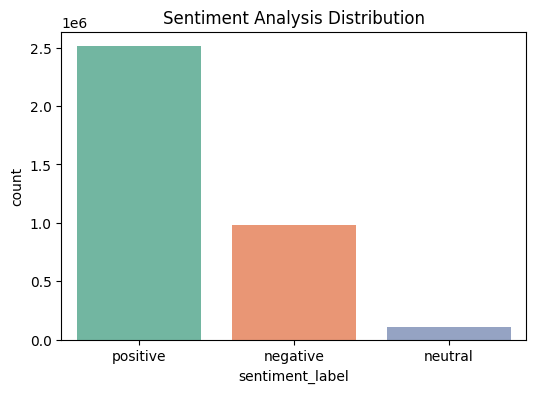

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="sentiment_label", palette="Set2")
plt.title("Sentiment Analysis Distribution")
plt.show()


STEP 7: COUNTING NAMED ENTITIES

In [31]:
from collections import Counter

# Store extracted entities
entities = []

# Run spaCy’s NER on a sample of reviews (adjust 500 as needed for performance)
for doc in nlp.pipe(df["clean_review"].head(500)):
    for ent in doc.ents:
        if ent.label_ in ["ORG", "PRODUCT"]:  # You can also add PERSON, GPE etc.
            entities.append(ent.text.strip())

# Count and display the most common entities
entity_counts = Counter(entities).most_common(10)

print("🔎 Top mentioned brands/products:")
for name, count in entity_counts:
    print(f"{name}: {count}")


🔎 Top mentioned brands/products:
sony: 4
bbc: 2
nikki: 2
lincoln: 2
veronica haddon: 1
kodak: 1
bbc soap: 1
bbc america: 1
abc: 1
rochelle: 1


This step answers: What product or brand names do people talk about most in the reviews?


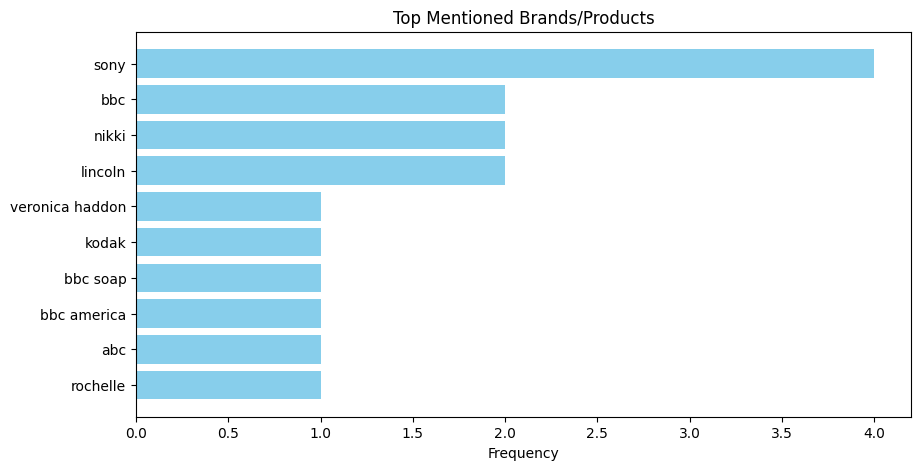

In [32]:
import matplotlib.pyplot as plt

# Separate names and counts
names, counts = zip(*entity_counts)

plt.figure(figsize=(10, 5))
plt.barh(names, counts, color='skyblue')
plt.xlabel("Frequency")
plt.title("Top Mentioned Brands/Products")
plt.gca().invert_yaxis()
plt.show()


STEP 8: SENTIMENT SAMPLES

In [36]:
df[["clean_review", "sentiment_label"]].sample(5)


,clean_review,sentiment_label
1517530,indeed a book for the stars it is detailed it ...,positive
2785512,you dont want to miss this this is diana wynne...,positive
2873834,horse facts for little kids i bought this to s...,negative
874419,live still cannot match the k games i rented b...,positive
941904,too much cheap acting and drama the actions fl...,negative
